In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn.functional as F
from optimizer import PruneAdam
from model import LeNet, AlexNet
from utils import regularized_nll_loss, admm_loss, \
    initialize_Z_and_U, update_X, update_Z, update_Z_l1, update_U, \
    print_convergence, print_prune, apply_prune, apply_l1_prune
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt


# 三步式训练网络

In [2]:
def train(args, model, device, train_loader, test_loader, optimizer):
    for epoch in range(args.num_pre_epochs):
        print('Pre epoch: {}'.format(epoch + 1))
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = regularized_nll_loss(args, model, output, target)
            loss.backward()
            optimizer.step()
        test(args, model, device, test_loader)

    Z, U = initialize_Z_and_U(model)   #初始化 Z，U
    for epoch in range(args.num_epochs):
        model.train()
        print('Epoch: {}'.format(epoch + 1))
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = admm_loss(args, device, model, Z, U, output, target)
            loss.backward()
            optimizer.step()
        X = update_X(model)  #更新X
        Z = update_Z_l1(X, U, args) if args.l1 else update_Z(X, U, args)  #根据稀疏项 选择跟新Z 方式
        U = update_U(U, X, Z)                                             #乘子更新
        print_convergence(model, X, Z)                                    #输出收敛率
        test(args, model, device, test_loader)


def test(args, model, device, test_loader):                              #测试函数
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def retrain(args, model, mask, device, train_loader, test_loader, optimizer):
    for epoch in range(args.num_re_epochs):
        print('Re epoch: {}'.format(epoch + 1))
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.prune_step(mask)

        test(args, model, device, test_loader)


In [3]:
#------------------画出权重的分布图-------------------------------------
def plot_weights(model):
    modules = [module for module in model.modules()]
    num_sub_plot = 0
    for i, layer in enumerate(modules):
        if hasattr(layer, 'weight'):
            plt.subplot(151+num_sub_plot)
            w = layer.weight.data
            w_one_dim = w.cpu().numpy().flatten()
            plt.hist(w_one_dim[w_one_dim!=0], bins=50)
            num_sub_plot += 1
    plt.show()

In [4]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--dataset', type=str, default="mnist", choices=["mnist", "cifar10"],
                        metavar='D', help='training dataset (mnist or cifar10)')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--percent', type=list, default=[0.8, 0.92, 0.991, 0.93],
                        metavar='P', help='pruning percentage (default: 0.8)')
    parser.add_argument('--alpha', type=float, default=5e-4, metavar='L',
                        help='l2 norm weight (default: 5e-4)')
    parser.add_argument('--rho', type=float, default=1e-2, metavar='R',
                        help='cardinality weight (default: 1e-2)')
    parser.add_argument('--l1', default=True, action='store_true',
                        help='prune weights with l1 regularization instead of cardinality')
    parser.add_argument('--l2', default=False, action='store_true',
                        help='apply l2 regularization')
    parser.add_argument('--num_pre_epochs', type=int, default=3, metavar='P',
                        help='number of epochs to pretrain (default: 3)')
    parser.add_argument('--num_epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--num_re_epochs', type=int, default=3, metavar='R',
                        help='number of epochs to retrain (default: 3)')
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-2)')
    parser.add_argument('--adam_epsilon', type=float, default=1e-8, metavar='E',
                        help='adam epsilon (default: 1e-8)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()

    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if args.dataset == "mnist":
        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=args.batch_size, shuffle=True, **kwargs)

        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('data', train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=args.test_batch_size, shuffle=True, **kwargs)

    else:
        args.percent = [0.8, 0.92, 0.93, 0.94, 0.95, 0.99, 0.99, 0.93]
        args.num_pre_epochs = 5
        args.num_epochs = 20
        args.num_re_epochs = 5
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=args.batch_size, **kwargs)

        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=args.test_batch_size, **kwargs)

    model = LeNet().to(device) if args.dataset == "mnist" else AlexNet().to(device)
    optimizer = PruneAdam(model.named_parameters(), lr=args.lr, eps=args.adam_epsilon)

    train(args, model, device, train_loader, test_loader, optimizer)
    mask = apply_l1_prune(model, device, args) if args.l1 else apply_prune(model, device, args)
    print_prune(model)
    test(args, model, device, test_loader)
    retrain(args, model, mask, device, train_loader, test_loader, optimizer)
    plot_weights(model)
    

if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--dataset D] [--batch-size N]
                             [--test-batch-size N] [--percent P] [--alpha L]
                             [--rho R] [--l1] [--l2] [--num_pre_epochs P]
                             [--num_epochs N] [--num_re_epochs R] [--lr LR]
                             [--adam_epsilon E] [--no-cuda] [--seed S]
                             [--save-model]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\liuzhi\AppData\Roaming\jupyter\runtime\kernel-b5085626-9fe6-47c2-af3c-437e8b965138.json


SystemExit: 2

C:\Users\liuzhi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
##收敛速率图
import numpy as np
from matplotlib import pyplot as plt

In [11]:
conv1 =[0.4139, 0.2158, 0.3187, 0.2495, 0.2574, 0.2619, 0.2784, 0.2464, 0.2500, 0.2665, 0.2746, 0.2697, 0.2581, 0.2264, 0.2713, 0.2573, 0.2797, 0.3061, 0.2954, 0.2644 ]
conv2 =[1.0005, 1.1077, 1.2507, 1.4049, 1.4703, 1.5004, 1.5717, 1.6381, 1.6985, 1.6517, 1.7374, 1.7923, 1.7504, 1.8199, 1.8385, 1.8477, 1.9501, 1.8139, 1.8432, 1.9091 ]
fc1 = [1.3074, 1.7413, 1.8748, 2.0698, 2.3143, 2.3858, 2.4539, 2.6695, 2.6559, 2.6065, 2.7859, 2.9138, 2.7643, 2.7367, 2.8321, 2.8412, 3.1345, 3.0306, 2.7924, 2.9811 ]
fc2 = [0.1843, 0.2990, 0.3810, 0.4356, 0.4923, 0.5391, 0.6014, 0.6331, 0.6339, 0.6503, 0.7046, 0.7239, 0.7004, 0.7659, 0.8048, 0.7725, 0.7712, 0.7622, 0.8074, 0.7952 ]


In [22]:
conv1.sort(reverse = True)
conv2.sort(reverse = True)
fc1.sort(reverse = True)
fc2.sort(reverse = True)

In [20]:
print(conv1)

[0.4139, 0.3187, 0.3061, 0.2954, 0.2797, 0.2784, 0.2746, 0.2713, 0.2697, 0.2665, 0.2644, 0.2619, 0.2581, 0.2574, 0.2573, 0.25, 0.2495, 0.2464, 0.2264, 0.2158]


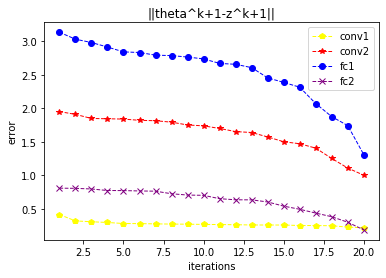

In [26]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')
plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','fc1','fc2'])
plt.show()

In [28]:
conv1 =[1.0236,0.1606 ,0.1305, 0.2257, 0.2471, 0.2367, 0.2376, 0.2592, 0.1966, 0.1891, 0.2032, 0.1851, 0.1517, 0.1595, 0.1071, 0.1104, 0.1077, 0.1109, 0.1310, 0.1225]
conv2 =[5.4720, 2.0418 ,1.5269 ,1.9864, 2.2885, 2.2349, 1.9534, 1.6453, 1.4836, 1.2958, 1.2186, 1.1581, 1.0154, 1.0101, 1.0089, 0.9144, 0.9810, 0.9478, 0.9457, 0.9114]
fc1 = [17.3771, 10.6004 ,8.0636, 8.9325, 8.4584, 7.2533, 6.0397, 5.2212, 4.8422, 4.3072, 4.0095, 4.0939, 3.7492, 3.2695, 3.1529, 2.8645, 2.7403, 2.6086, 2.4851 ,2.3359]
fc2 = [2.3444, 1.1313 ,0.6199, 0.6068 ,0.7746, 0.8373, 0.8234, 0.7461, 0.7109, 0.6643, 0.6249, 0.5966, 0.5610, 0.4885, 0.4651, 0.3980, 0.3996, 0.3905, 0.3497, 0.3204]


In [29]:
conv1.sort(reverse = True)
conv2.sort(reverse = True)
fc1.sort(reverse = True)
fc2.sort(reverse = True)

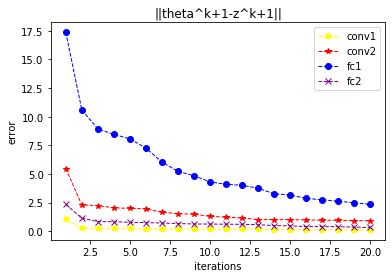

In [30]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')
plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','fc1','fc2'])
plt.show()

In [32]:
conv1 =[0.3310,  0.0484, 0.0567, 0.0859, 0.0963, 0.0976,  0.1010, 0.0975,  0.0845, 0.0638]
conv2 =[0.6422,  0.2264, 0.2246, 0.3113, 0.3224,  0.2983, 0.2786, 0.2488, 0.2166, 0.2168]
fc1 =[0.7652, 0.5630, 0.5689, 0.5877, 0.5486, 0.5089, 0.4754, 0.4369, 0.4037, 0.4007]
fc2 =[0.7338, 0.3413, 0.2136, 0.2447, 0.2726, 0.2584, 0.2380, 0.2129, 0.2035, 0.1923]

In [33]:
conv1.sort(reverse = True)
conv2.sort(reverse = True)
fc1.sort(reverse = True)
fc2.sort(reverse = True)

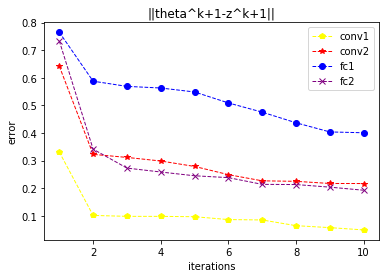

In [34]:
x = [1,2,3,4,5,6,7,8,9,10]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')
plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','fc1','fc2'])
plt.show()

In [37]:
conv1 =[0.6674,0.9453,1.0595,1.3609,1.2406 ,1.5183,1.4210,1.4471,1.4801, 1.5842,1.4862,1.5450, 1.5212,1.5093,1.4787,1.5582,1.4687,1.5341,1.5009,1.5108]
conv2 =[0.6921, 0.7373,0.8098,0.8539,0.8901,0.9095,0.9248,0.9400,0.9525,0.9612 ,0.9733,0.9811,0.9869,0.9854,0.9818,0.9868,0.9799,0.9765,0.9711,0.9704]
conv3 =[0.5714,0.6373,0.5762,0.6139,0.6343,0.6361,0.6369,0.6410,0.6396,0.6378,0.6419,0.6402,0.6453,0.6448,0.6432,0.6409,0.6393,0.6314,0.6249,0.6258]
conv4 =[0.6106,0.7149,0.7674,0.8211, 0.8548,0.8759,0.8970,0.9155,0.9345, 0.9540,0.9736,0.9939,1.0147,1.0350,1.0526,1.0689,1.0832,1.0935,1.1047,1.1154]
conv5 =[0.7221,0.8393,0.9435,1.0167,1.0562,1.0830,1.1072,1.1264,1.1491, 1.1730,1.1924,1.2122,1.2332,1.2506,1.2676,1.2881,1.3056,1.3188,1.3285,1.3445] 
fc1 =[0.9172,0.9764,1.0683,1.1179,1.1351,1.1408,1.1332,1.1266,1.1215, 1.1201,1.1206,1.1187,1.1164,1.1155,1.1158,1.1142,1.1124,1.1081,1.1094,1.1074]
fc2 =[0.8681,0.8824,0.7317,0.6485,0.5663,0.4701,0.3893,0.3412,0.2820,0.2335,0.1959,0.1714,0.1542,0.1519,0.1512,0.1434,0.1364,0.1451,0.1535,0.1561]
fc3 =[0.6166,0.6472,0.5711,0.5011,0.4409,0.3822 ,0.3275,0.2824,0.2534, 0.2190, 0.1684,0.1464,0.1311,0.1275,0.1232,0.1200,0.1130,0.1264,0.1382,0.1416]

In [38]:
conv1.sort(reverse = True)
conv2.sort(reverse = True)
conv3.sort(reverse = True)
conv4.sort(reverse = True)
conv5.sort(reverse = True)
fc1.sort(reverse = True)
fc2.sort(reverse = True)
fc3.sort(reverse = True)

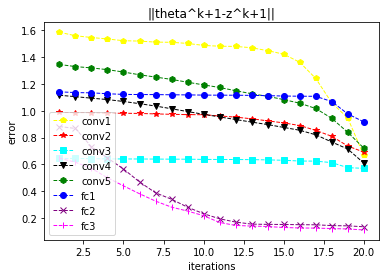

In [39]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')

plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')

plt.plot(x,conv3,color = 'cyan',linewidth = 1, label = 'conv3',linestyle = '--',marker = 's')
plt.plot(x,conv4,color = 'black',linewidth = 1, label = 'conv4',linestyle = '--',marker = 'v')
plt.plot(x,conv5,color = 'green',linewidth = 1, label = 'conv5',linestyle = '--',marker = 'h')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.plot(x,fc3,color = 'magenta',linewidth = 1, label = 'fc3',linestyle = '--',marker = '|')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','conv3','conv4','conv5','fc1','fc2','fc3'])
plt.show()

In [10]:
a=1

In [13]:

if a>1:
    print('a >1')
elif a<1 :
    print(a<1)
elif a == 1:
    print( 'a = 1')

a = 1


In [14]:
b = 1 if (a>1) elif (a<1) 2 elif (a==1) 3

SyntaxError: invalid syntax (<ipython-input-14-58537b64cee6>, line 1)

In [6]:
conv1 =[ 0.7059,0.5511,0.4370,0.4296,0.3585,0.3263,0.3266,0.3016,0.2776,0.2480,0.2501,0.2313,0.2155,0.2019,0.1828,0.1735,0.1640,0.1524,0.1365,0.1279,0.1248,0.1207,0.1172,0.1082,0.0997,0.1073,0.0993,0.1027,0.0928,0.0911]
conv2 =[0.9994,0.9130,0.9146,0.9138,0.8918,0.8158,0.8027,0.7482,0.7008,0.6443,0.6073,0.5679,0.5296,0.4913,0.4589, 0.4378,0.4166,0.3936,0.3706,0.3548,0.3441,0.3339,0.3133,0.3001,0.2875,0.2813,0.2723,0.2621,0.2527,0.2480]
fc1 =[0.9999,0.9828,0.9800,0.9738,0.9629,0.9131,0.8801,0.8311,0.7818,0.7283,0.6864,0.6393,0.5873,0.5427,0.5130,0.4986,0.4497, 0.4216,0.3958,0.3530, 0.3254,0.3143,0.2928,0.2705,0.2500,0.2434,0.2405,0.2346,0.2264,0.2241]
fc2 =[1.0000,0.9630,0.9364,0.9826,0.9678,0.7774,0.7445,0.6869,0.6284,0.5435,0.4801,0.4181,0.3656,0.3319,0.2918,0.2609,0.2362,0.2258,0.2021,0.1843,0.1682,0.1536, 0.1422,0.1265,0.1159,0.1093, 0.1036,0.0949,0.0953,0.0895]

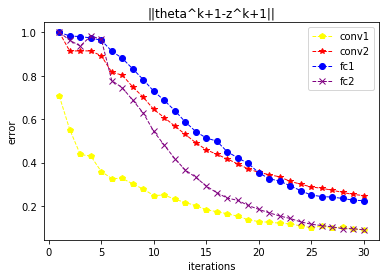

In [3]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')
plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','fc1','fc2'])
plt.show()

In [7]:
conv1.sort(reverse = True)
conv2.sort(reverse = True)
fc1.sort(reverse = True)
fc2.sort(reverse = True)

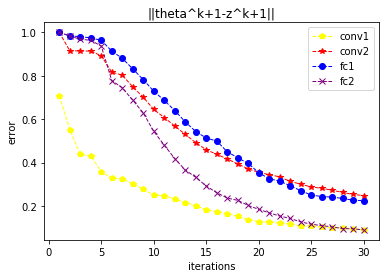

In [8]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')
plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','fc1','fc2'])
plt.show()

In [2]:
conv1 =[ 0.7059,0.5511,0.4370,0.4296,0.3585,0.3263,0.3266,0.3016,0.2776,0.2480,0.2501,0.2313,0.2155,0.2019,0.1828,0.1735,0.1640,0.1524,0.1365,0.1279,0.1248,0.1207,0.1172,0.1082,0.0997,0.1073,0.0993,0.1027,0.0928,0.0911]
conv2 =[0.9994,0.9130,0.9146,0.9138,0.8918,0.8158,0.8027,0.7482,0.7008,0.6443,0.6073,0.5679,0.5296,0.4913,0.4589, 0.4378,0.4166,0.3936,0.3706,0.3548,0.3441,0.3339,0.3133,0.3001,0.2875,0.2813,0.2723,0.2621,0.2527,0.2480]
fc1 =[0.9999,0.9828,0.9800,0.9738,0.9629,0.9131,0.8801,0.8311,0.7818,0.7283,0.6864,0.6393,0.5873,0.5427,0.5130,0.4986,0.4497, 0.4216,0.3958,0.3530, 0.3254,0.3143,0.2928,0.2705,0.2500,0.2434,0.2405,0.2346,0.2264,0.2241]
fc2 =[1.0000,0.9630,0.9364,0.9826,0.9678,0.7774,0.7445,0.6869,0.6284,0.5435,0.4801,0.4181,0.3656,0.3319,0.2918,0.2609,0.2362,0.2258,0.2021,0.1843,0.1682,0.1536, 0.1422,0.1265,0.1159,0.1093, 0.1036,0.0949,0.0953,0.0895]

In [3]:
conv1.sort(reverse = True)
conv2.sort(reverse = True)
fc1.sort(reverse = True)
fc2.sort(reverse = True)

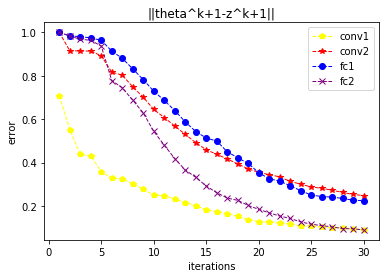

In [4]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.figure
plt.plot(x,conv1,color = 'yellow',linewidth = 1, label = 'conv1',linestyle = '--',marker = 'p')
plt.plot(x,conv2,color = 'red',linewidth = 1, label = 'conv2',linestyle = '--',marker = '*')
plt.plot(x,fc1,color = 'blue',linewidth = 1, label = 'fc1',linestyle = '--',marker = 'o')
plt.plot(x,fc2,color = 'purple',linewidth = 1, label = 'fc2',linestyle = '--',marker = 'x')
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('||theta^k+1-z^k+1||')
plt.legend(['conv1','conv2','fc1','fc2'])
plt.show()

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn.functional as F
from optimizer import PruneAdam
from model import LeNet, AlexNet
from torchvision import datasets, transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from torchstat import stat

model = torch.load('pruning_modelnet.pkl')

In [8]:
stat(model, (1, 28, 28))

      module name  input shape output shape    params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0           conv1    1  28  28   20  24  24     520.0       0.04    576,000.0    299,520.0      5216.0      46080.0      85.42%    51296.0
1           conv2   20  12  12   50   8   8   25050.0       0.01  3,200,000.0  1,603,200.0    111720.0      12800.0       0.00%   124520.0
2             fc1          800          500  400500.0       0.00    799,500.0    400,000.0   1605200.0       2000.0      12.50%  1607200.0
3             fc2          500           10    5010.0       0.00      9,990.0      5,000.0     22040.0         40.0       2.08%    22080.0
total                                        431080.0       0.06  4,585,490.0  2,307,720.0     22040.0         40.0     100.00%  1805096.0
Total params: 431,080
------------------------------------------------------------------------------------------------------------------------------------------
Total